In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
import HDF5
using Optim

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [3]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [4]:
function hist_2d(smpls, dim_1, dim_2; nbins=35, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [5]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

prior_11 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [2.9], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

prior_12 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [2.9], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

prior_13 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [2.9], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        resy = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

prior_21 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.55 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
)

prior_22 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.55 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
)

prior_23 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.55 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        resy = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

In [6]:
FPATH = "../../data/sampling_results/Benchmark-12/"

"../../data/sampling_results/Benchmark-12/"

In [7]:
smpl_tmp = bat_read(FPATH*"samples-11.hdf5").result
samples_11 = varshape(prior_11).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-12.hdf5").result
samples_12 = varshape(prior_12).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-13.hdf5").result
samples_13 = varshape(prior_13).(smpl_tmp);

smpl_tmp = bat_read(FPATH*"samples-21.hdf5").result
samples_21 = varshape(prior_21).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-22.hdf5").result
samples_22 = varshape(prior_22).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-23.hdf5").result
samples_23 = varshape(prior_23).(smpl_tmp);

In [8]:
kkk = bat_eff_sample_size(samples_23).result

ShapedAsNT((tr_size = [377.48489875802693, 538.0947180216033], tr_size_2 = [421.08107718380177, 483.55895323438295], ang_spr = [372.13352358021325, 530.0429313049171], ang_spr_2 = [284.2028535403162, 478.40613228319796], mixt_pow = 793.2361112176621, waist = [644.8293387181362], waist_2 = [884.3307981116438], algmx = [1055.5752683007904, 1127.1360319738599, 998.2817937193965, 1029.6373250614727], algmy = [926.1011782285636, 887.8729951038678, 1087.0906718358613, 1127.6214920261864], cam4_ped = 692.5362605761824, cam4_light_fluct = 1090.8651710099527, cam4_light_amp = 978.4023917185654, resx = [467.4477770698393, 382.6890277292571, 283.2891968817166], resy = [545.0900943758267, 279.87231428402674, 408.924497471978], cam4_resx = 272.54994991905807, cam4_resy = 461.722939509531, psx = [612.1347598799829, 700.0648200184568, 735.1091045207879], psy = [710.4906226109772, 823.5932189793418, 443.0317242635456], cam4_psx = 637.995312174087, cam4_psy = 740.775838880667, light_amp = [789.80232839

In [9]:
round(Int, minimum(unshaped(kkk)))

273

In [10]:

# samples_unweighted = bat_sample(samples_23, OrderedResampling(nsamples=10^4)).result

In [11]:
[size(flatview(unshaped.(samples_11.v))), size(flatview(unshaped.(samples_12.v))), size(flatview(unshaped.(samples_13.v)))]

3-element Vector{Tuple{Int64, Int64}}:
 (21, 500598)
 (29, 456361)
 (35, 432395)

In [12]:
[size(flatview(unshaped.(samples_21.v))), size(flatview(unshaped.(samples_22.v))), size(flatview(unshaped.(samples_23.v)))]

3-element Vector{Tuple{Int64, Int64}}:
 (27, 472740)
 (35, 451600)
 (41, 406279)

In [13]:
[length(samples_11), length(samples_12), length(samples_13), length(samples_21), length(samples_22), length(samples_23)]

6-element Vector{Int64}:
 500598
 456361
 432395
 472740
 451600
 406279

In [14]:
400/125

3.2

In [15]:
mean(samples_21)

ShapedAsNT((tr_size = [0.08962601138344506, 0.13279630723247132], tr_size_2 = [0.13176412236025195, 0.15265933363053544], ang_spr = [6.222935137678962, 5.759259167363568], ang_spr_2 = [2.6004905693890294, 2.37937277242284], mixt_pow = 0.6650873464726307, waist = [3.140648350631113], waist_2 = [2.851222569839136], algmx = [31.737375636142627, 32.2193260827561, 21.298441230385254, 35.238376441542925], algmy = [36.94028911189161, 37.42826789293065, 20.231468383701507, 33.90526581056345], cam4_ped = 27.550523204886506, cam4_light_fluct = 1.36226257155492, cam4_light_amp = 8.843984048943048, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.830213813714564, cam4_resy = 4.773588815370763, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.528135071306414, 11.423120951474125, 2.6882977005416464], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [16]:
plot_envelop_trajectory(mean(samples_21))

LoadError: UndefVarError: labels_array not defined

In [17]:
mean(samples_21).cam4_resx*

LoadError: syntax: incomplete: premature end of input

In [18]:
mean(samples_21).cam4_psx

121.8

In [19]:
mean(samples_21).resx.*mean(samples_21).psx

3-element Vector{Float64}:
  27.1
  21.6
 114.0

In [20]:
BTV 412350 (Silicon coated by silver screen) : 27.1 μm
BTV 412353 (Silicon coated by silver screen) : 21.6 μm
BTV 412426 (Silicon coated by silver screen) : 114.0 μm
BTV 412442 (Chromox screen) : 588.32 μm

LoadError: syntax: extra token "412350" after end of expression

In [20]:
mean(samples_21).cam4_resy*mean(samples_21).cam4_psy

0-dimensional Array{Float64, 0}:
572.8306578444916

In [21]:
function plot_contour(ax, hist; kwargs...)
    ax.contour(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

function plot_contourf(ax, hist; kwargs...)
    ax.contourf(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

plot_contourf (generic function with 1 method)

In [22]:
hist_11 = hist_2d(samples_11, 1,2)
hist_12 = hist_2d(samples_12, 1,2)
hist_13 = hist_2d(samples_13, 1,2)

hist_211 = hist_2d(samples_21, 1,2)
hist_212 = hist_2d(samples_21, 3,4)

hist_221 = hist_2d(samples_22, 1,2)
hist_222 = hist_2d(samples_22, 3,4)

hist_231 = hist_2d(samples_23, 1,2)
hist_232 = hist_2d(samples_23, 3,4);

In [23]:
min_vals = -73700.38088631934

i_11 = [-73649.38088631934, -73651.6982440232] .- min_vals
i_12 = [-73538.94357576006, -73541.2350409309] .- min_vals
i_13 = [-73491.52053144189, -73494.37750708264] .- min_vals
i_21 = [-71980.00078991472, -71983.18498602472] .- min_vals
i_22 = [-71885.77803492927, -71887.9727737773] .- min_vals
i_23 = [-71880.08336777825, -71880.45707944027] .- min_vals

2-element Vector{Float64}:
 1820.2975185410905
 1819.9238068790728

In [24]:
# custom_cmaps: 

clist = [(0,"white"), (1, "#1b9e77")] #green
cmap_3 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap", clist)
col_3 = "#1b9e77"

clist = [(0,"white"), (1, "#d95f02")] #orange
cmap_1 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap", clist)
col_1 = "#d95f02"

clist = [(0,"white"), (1, "#7570b3")] # violet
cmap_2 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap", clist)
col_2 = "#7570b3"

"#7570b3"

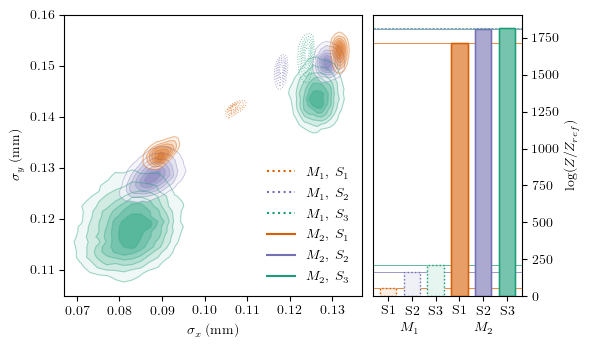

PyObject Text(0.835, 0.01, '$M_2$')

In [29]:
labels = ["S1", "S2", "S3", "S1", "S2", "S3"]
lab_ind = 1:6

figsize = (6,4)
figsize = (5.905631659056317, 3.649881090334235)
fig, (ax, ax2) = plt.subplots(1,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[2, 1]))
fig.subplots_adjust(hspace=0.0, wspace=0.05)

plot_contour(ax, hist_11, colors=col_1, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_12, colors=col_2, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_13, colors=col_3, linewidths=0.7, alpha=0.6, linestyles=:dotted)

# plot_contourf(ax, hist_11, cmap=:Blues, linewidths=0.8, alpha=0.5, )
# plot_contourf(ax, hist_12, cmap=:Oranges, linewidths=0.8, alpha=0.5,)
# plot_contourf(ax, hist_13, cmap=:Greens, linewidths=0.8, alpha=0.5,)

# 2G Model:

plot_contourf(ax, hist_231, cmap=cmap_3, alpha=0.8, )
plot_contourf(ax, hist_232, cmap=cmap_3, alpha=0.8,)
plot_contour(ax, hist_231, colors=col_3, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_232, colors=col_3, linewidths=0.8, alpha=0.4, )

plot_contourf(ax, hist_221, cmap=cmap_2, alpha=0.8, )
plot_contourf(ax, hist_222, cmap=cmap_2, alpha=0.8,)
plot_contour(ax, hist_221, colors=col_2, linewidths=0.6, alpha=0.4, )
plot_contour(ax, hist_222, colors=col_2, linewidths=0.6, alpha=0.4, )

plot_contourf(ax, hist_211, cmap=cmap_1, alpha=0.8, )
plot_contourf(ax, hist_212, cmap=cmap_1, alpha=0.8,)
plot_contour(ax, hist_211, colors=col_1, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_212, colors=col_1, linewidths=0.8, alpha=0.4,)

ax2.axhline(i_11[1], zorder=-100, linewidth=0.5, color=col_1, )
ax2.axhline(i_12[1], zorder=-100, linewidth=0.5, color=col_2, )
ax2.axhline(i_13[1], zorder=-100, linewidth=0.5, color=col_3, )

ax2.axhline(i_21[1], zorder=-100, linewidth=0.5, color=col_1, )
ax2.axhline(i_22[1], zorder=-100, linewidth=0.5, color=col_2, )
ax2.axhline(i_23[1], zorder=-100, linewidth=0.5, color=col_3, linestyle="--")

ax2.bar(1, i_11[1], width=0.7, color=:white, edgecolor=col_1, linestyle=":")
ax2.bar(2, i_12[1], width=0.7, color=:white, edgecolor=col_2, linestyle=":")
ax2.bar(3, i_13[1], width=0.7, color=:white, edgecolor=col_3, linestyle=":")

ax2.bar(1, i_11[1], width=0.7, color=col_1, edgecolor=col_1, alpha=0.1)
ax2.bar(2, i_12[1], width=0.7, color=col_2, edgecolor=col_2, alpha=0.1)
ax2.bar(3, i_13[1], width=0.7, color=col_3, edgecolor=col_3, alpha=0.1)

ax2.bar(4, i_21[1], width=0.7, color=:white, edgecolor=col_1,)
ax2.bar(5, i_22[1], width=0.7, color=:white, edgecolor=col_2,)
ax2.bar(6, i_23[1], width=0.7, color=:white, edgecolor=col_3,)

ax2.bar(4, i_21[1], width=0.7, color=col_1, edgecolor=col_1, alpha=0.6)
ax2.bar(5, i_22[1], width=0.7, color=col_2, edgecolor=col_2, alpha=0.6)
ax2.bar(6, i_23[1], width=0.7, color=col_3, edgecolor=col_3, alpha=0.6)

ax.plot(-10, 10, linestyle=":", color=col_1, label=L"M_1,\; S_1")
ax.plot(-10, 10, linestyle=":", color=col_2, label=L"M_1,\; S_2")
ax.plot(-10, 10, linestyle=":", color=col_3, label=L"M_1,\; S_3")
ax.plot(-10, 10, linestyle="-", color=col_1, label=L"M_2,\; S_1")
ax.plot(-10, 10, linestyle="-", color=col_2, label=L"M_2,\; S_2")
ax.plot(-10, 10, linestyle="-", color=col_3, label=L"M_2,\; S_3")
ax.legend(loc="lower right", framealpha=0.0)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.set_xticks(lab_ind)
ax2.set_xticklabels(labels)

ax.set_xlim(0.067, 0.137)
ax.set_ylim(0.105, 0.16)

ax.set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax.set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax2.set_ylabel(L"\log(Z/Z_{ref})")

fig.text(0.71, 0.01, L"M_1", ha="center")
fig.text(0.835, 0.01, L"M_2", ha="center")

# fig.savefig("../../plots/params.pdf", bbox_inches = "tight")

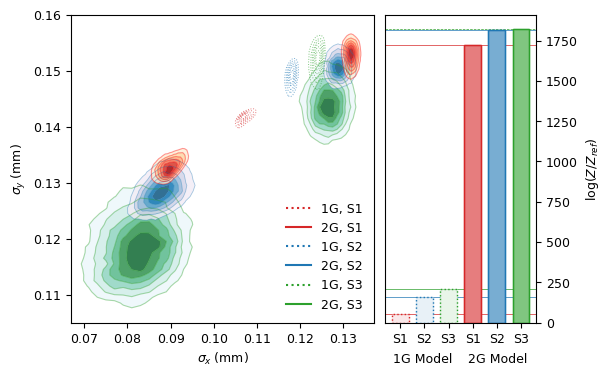

PyObject Text(0.835, 0.01, '2G Model')

In [27]:
labels = ["S1", "S2", "S3", "S1", "S2", "S3"]
lab_ind = 1:6

fig, (ax, ax2) = plt.subplots(1,2, figsize=(6,4), gridspec_kw=Dict("width_ratios"=>[2, 1]))
fig.subplots_adjust(hspace=0.0, wspace=0.05)

plot_contour(ax, hist_11, colors=:C3, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_12, colors=:C0, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_13, colors=:C2, linewidths=0.7, alpha=0.6, linestyles=:dotted)

# plot_contourf(ax, hist_11, cmap=:Blues, linewidths=0.8, alpha=0.5, )
# plot_contourf(ax, hist_12, cmap=:Oranges, linewidths=0.8, alpha=0.5,)
# plot_contourf(ax, hist_13, cmap=:Greens, linewidths=0.8, alpha=0.5,)

# 2G Model:

plot_contourf(ax, hist_231, cmap=:BuGn, alpha=0.8, )
plot_contourf(ax, hist_232, cmap=:BuGn, alpha=0.8,)
plot_contour(ax, hist_231, colors=:C2, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_232, colors=:C2, linewidths=0.8, alpha=0.4, )

plot_contourf(ax, hist_221, cmap=:PuBu, alpha=0.8, )
plot_contourf(ax, hist_222, cmap=:PuBu, alpha=0.8,)
plot_contour(ax, hist_221, colors=:C0, linewidths=0.6, alpha=0.4, )
plot_contour(ax, hist_222, colors=:C0, linewidths=0.6, alpha=0.4, )

plot_contourf(ax, hist_211, cmap=:OrRd, alpha=0.8, )
plot_contourf(ax, hist_212, cmap=:OrRd, alpha=0.8,)
plot_contour(ax, hist_211, colors=:Red, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_212, colors=:Red, linewidths=0.8, alpha=0.4,)

ax2.axhline(i_11[1], zorder=-100, linewidth=0.5, color=:C3, )
ax2.axhline(i_12[1], zorder=-100, linewidth=0.5, color=:C0, )
ax2.axhline(i_13[1], zorder=-100, linewidth=0.5, color=:C2, )

ax2.axhline(i_21[1], zorder=-100, linewidth=0.5, color=:C3, )
ax2.axhline(i_22[1], zorder=-100, linewidth=0.5, color=:C0, )
ax2.axhline(i_23[1], zorder=-100, linewidth=0.5, color=:C2, linestyle="--")

ax2.bar(1, i_11[1], width=0.7, color=:white, edgecolor=:C3, linestyle=":")
ax2.bar(2, i_12[1], width=0.7, color=:white, edgecolor=:C0, linestyle=":")
ax2.bar(3, i_13[1], width=0.7, color=:white, edgecolor=:C2, linestyle=":")

ax2.bar(1, i_11[1], width=0.7, color=:C3, edgecolor=:C3, alpha=0.1)
ax2.bar(2, i_12[1], width=0.7, color=:C0, edgecolor=:C0, alpha=0.1)
ax2.bar(3, i_13[1], width=0.7, color=:C2, edgecolor=:C2, alpha=0.1)

ax2.bar(4, i_21[1], width=0.7, color=:white, edgecolor=:C3,)
ax2.bar(5, i_22[1], width=0.7, color=:white, edgecolor=:C0,)
ax2.bar(6, i_23[1], width=0.7, color=:white, edgecolor=:C2,)

ax2.bar(4, i_21[1], width=0.7, color=:C3, edgecolor=:C3, alpha=0.6)
ax2.bar(5, i_22[1], width=0.7, color=:C0, edgecolor=:C0, alpha=0.6)
ax2.bar(6, i_23[1], width=0.7, color=:C2, edgecolor=:C2, alpha=0.6)

ax.plot(-10, 10, linestyle=":", color=:C3, label="1G, S1")
ax.plot(-10, 10, linestyle="-", color=:C3, label="2G, S1")
ax.plot(-10, 10, linestyle=":", color=:C0, label="1G, S2")
ax.plot(-10, 10, linestyle="-", color=:C0, label="2G, S2")
ax.plot(-10, 10, linestyle=":", color=:C2, label="1G, S3")
ax.plot(-10, 10, linestyle="-", color=:C2, label="2G, S3")
ax.legend(loc="lower right", framealpha=0.0)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.set_xticks(lab_ind)
ax2.set_xticklabels(labels)

ax.set_xlim(0.067, 0.137)
ax.set_ylim(0.105, 0.16)

ax.set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax.set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax2.set_ylabel(L"\log(Z/Z_{ref})")

fig.text(0.71, 0.01, "1G Model", ha="center")
fig.text(0.835, 0.01, "2G Model", ha="center")

# Uncertainty Check: 

In [ ]:
function def_datasets(samples_init, samples_ext, indid; nsampls=60)
    samples_init = bat_sample(samples_init, OrderedResampling(nsamples=nsampls)).result
    samples_init = flatview(unshaped.(samples_init.v))
    samples_ext = bat_sample(samples_ext, OrderedResampling(nsamples=nsampls)).result
    samples_ext = flatview(unshaped.(samples_ext.v))
    
    samples_init = samples_init[indid,:] 
    samples_ext = samples_ext[indid,:] 
    
    return samples_init, samples_ext
end

In [ ]:
tmp_1 = def_datasets(samples_21, samples_23, [1,2,3,4,5,6,7,8,9,10,11]);

In [ ]:
function cost_func(params, samples_init, samples_ext)
    
    cost_total = 0.0
    npars = Int(length(params)/2)
    mean = params[1:npars]
    cv_mat = Diagonal(params[npars+1:end].^2) 
    
    for i in eachcol(samples_ext)
        ll_tmp = 0.0
        for j in eachcol(samples_init)
            ll_tmp += logpdf(MvNormal(j.-mean, cv_mat), i) 
        end
        cost_total += ll_tmp
    end
    return -cost_total
end

eval_cost(x) = cost_func(x, tmp_1[1], tmp_1[2])

In [ ]:
@time eval_cost(rand(22))

In [ ]:
lower = [repeat([-10.,], 11); repeat([0.,], 11)]
upper = [repeat([10.,], 11); repeat([10.,], 11)]
initial_x = repeat([0.1,], 22)
inner_optimizer = GradientDescent()

@time result = optimize(eval_cost, lower, upper, initial_x)

min_vals = Optim.minimizer(result)

In [ ]:
Optim.f_calls(result)

In [ ]:
npars_tmp = Int(length(min_vals)/2)
mean_tmp = min_vals[1:npars_tmp] #* 0.0
minimized_cv = Diagonal(min_vals[npars_tmp+1:end].^2) 

tmp_2 = def_datasets(samples_21, samples_23, [1,2,3,4,5,6,7,8,9,10,11], nsampls=10^4);

samples_corrected = [rand(MvNormal(i .- mean_tmp , minimized_cv)) for i in eachcol(tmp_2[1])];
samples_corrected = hcat(samples_corrected...);

In [ ]:
hist_new_1 = fit(Histogram, (samples_corrected[1,:],samples_corrected[2,:]), nbins=20)
hist_new_1 = normalize(hist_new_1, mode=:pdf) 

hist_new_2 = fit(Histogram, (samples_corrected[3,:],samples_corrected[4,:]), nbins=20)
hist_new_2 = normalize(hist_new_2, mode=:pdf) ;

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


plot_contour(ax, hist_new_1, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_new_2, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_211, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_212, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_231, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_232, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)

# ax.set_xlim(0.02, 0.2)
# ax.set_ylim(0.02, 0.2)

### Tst Data:

In [ ]:
smpl_tmp = bat_read(FPATH*"samples-21-test.hdf5").result
samples_test_21 = varshape(prior_21).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-23-test.hdf5").result
samples_test_23 = varshape(prior_23).(smpl_tmp);

In [ ]:
hist_test_211 = hist_2d(samples_test_21, 1,2)
hist_test_212 = hist_2d(samples_test_21, 3,4)

hist_test_231 = hist_2d(samples_test_23, 1,2)
hist_test_232 = hist_2d(samples_test_23, 3,4);

In [ ]:
npars_tmp = Int(length(min_vals)/2)
mean_tmp = min_vals[1:npars_tmp] #* 0.0
minimized_cv = Diagonal(min_vals[npars_tmp+1:end].^2) 

tmp_3 = def_datasets(samples_test_21, samples_test_23, [1,2,3,4,5,6,7,8,9,10,11], nsampls=10^4);

samples_corrected = [rand(MvNormal(i .- mean_tmp , minimized_cv)) for i in eachcol(tmp_3[1])];
samples_corrected = hcat(samples_corrected...);

In [ ]:
hist_new_12 = fit(Histogram, (samples_corrected[1,:],samples_corrected[2,:]), nbins=20)
hist_new_12 = normalize(hist_new_12, mode=:pdf) 

hist_new_22 = fit(Histogram, (samples_corrected[3,:],samples_corrected[4,:]), nbins=20)
hist_new_22 = normalize(hist_new_22, mode=:pdf) ;

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_contour(ax, hist_new_12, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_new_22, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_test_211, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_test_212, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_test_231, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_test_232, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)

# ax.set_xlim(0.02, 0.2)
# ax.set_ylim(0.02, 0.2)